### Data-driven optimization and decision making

### Final project

Juha Reinikainen

In [100]:
import numpy as np
import model
import data
import algorithm
import matplotlib.pyplot as plt
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

import warnings
warnings.simplefilter("ignore")

# reload changes to self written files
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
df = data.get_data_df()

n_stocks = df.shape[1]
population_size = 100
n_generations = 1000

#start with equal weight for each stock 1/50 = 0.02
wi = 1 / n_stocks
w0 = np.full(n_stocks, wi)

problem = model.PortfolioSelection(df, w0, 0.01, 0.8, 4, 20)
# problemArima = model.PortfolioSelectionArima(df, w0)

repairMethod = algorithm.OneSumRepair()

In [102]:
initial_population = algorithm.createWeightVectors(population_size, n_stocks)

nsga2 = NSGA2(pop_size = population_size, sampling=initial_population, repair = repairMethod)
res = minimize(problem, nsga2, ("n_gen", n_generations), seed=1, verbose = False)



In [103]:
# initial_population = algorithm.createWeightVectors(population_size, n_stocks)

# nsga2 = NSGA2(pop_size = population_size, sampling=initial_population, repair = repairMethod)
# resArima = minimize(problemArima, nsga2, ("n_gen", n_generations), seed=1, verbose = False)


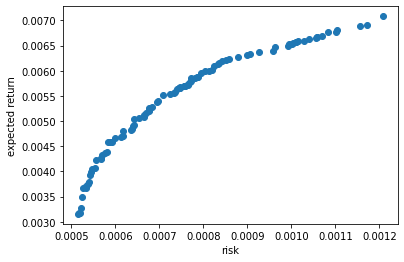

In [104]:
plt.scatter(res.F[:,1], -res.F[:,0], label="simple")
# plt.scatter(resArima.F[:,1], -resArima.F[:,0], label="arima")
plt.xlabel("risk")
plt.ylabel("expected return")
# plt.legend()
plt.show()